In [35]:
import re
import IPython
import torch
import torchaudio
from torchaudio import transforms as T
import pandas as pd
import numpy as np

from tqdm import tqdm

from IPython.display import Audio
from matplotlib.patches import Rectangle
import librosa


from torchaudio.pipelines import MMS_FA as bundle
from matplotlib import pyplot as plt
from typing import List
from pypinyin import lazy_pinyin, Style

from utils.constants import *
from utils.dataset import GetDevice
import json

tqdm.pandas(desc="Processing data")


In [36]:
new_df = pd.read_csv('./large-corpus/prepped.csv')

In [38]:
new_df['transcript'].apply(json.loads)[0]

['mo', 'shi', 'zhong', 'cai', 'yang', 'zi', 'tai', 'wan', 'gui', 'shan', 'dao']

In [39]:
new_df.shape

(600247, 7)

In [2]:
df = pd.read_csv('./large-corpus/other.tsv', sep='\t')

/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_89245/749438795.py:1: DtypeWarning: Columns (4,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./large-corpus/other.tsv', sep='\t')


In [3]:
df = df[['path', 'sentence', 'age', 'gender', 'accents']]

In [27]:
df.tail(10)

,path,sentence,age,gender,accents
600237,common_voice_zh-CN_41891242.mp3,它是西半球最大的科学博物馆。,thirties,NaN,出生地：51 四川省
600238,common_voice_zh-CN_41891243.mp3,总的来说，美国从政策和制度上在乌克兰开展反对俄罗斯的活动包括经济援助、军事援助、外交压力、信...,thirties,NaN,出生地：51 四川省
600239,common_voice_zh-CN_41891244.mp3,智深道：“胡说，这等一个大去处，不信没斋粮。,thirties,NaN,出生地：51 四川省
600240,common_voice_zh-CN_41891245.mp3,輕輕敲醒沉睡的心靈，慢慢張開你地眼睛,thirties,NaN,出生地：51 四川省
600241,common_voice_zh-CN_41891246.mp3,中华民国主权属于国民全体,thirties,NaN,出生地：51 四川省
600242,common_voice_zh-CN_41891247.mp3,炫家军来也！,thirties,NaN,出生地：51 四川省
600243,common_voice_zh-CN_41891248.mp3,索伊贝尔斯多尔夫是德国巴伐利亚州的一个市镇。,thirties,NaN,出生地：51 四川省
600244,common_voice_zh-CN_41891249.mp3,情报侦察：乌克兰军队通过加强情报侦察工作，及时获得敌方无人机的动向和部署情况，从而能够提前采...,thirties,NaN,出生地：51 四川省
600245,common_voice_zh-CN_41907107.mp3,三,NaN,NaN,NaN
600246,common_voice_zh-CN_41907108.mp3,数据集包含真实、仿真和干净的录音。,NaN,NaN,NaN


In [5]:
torchaudio.load(LARGE_16K_DIR / df['path'][0])

(tensor([[-1.1826e-05, -3.8991e-05, -1.4978e-05,  ..., -1.4315e-04,
          -1.3605e-05,  2.1167e-05]]),
 16000)

In [6]:
device = 'cpu'

In [7]:

model = bundle.get_model()
model.to(device)

tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()


In [8]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript))
    return emission, token_spans


In [9]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start, t_spans[-1].end
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    fig.tight_layout()


In [10]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)


In [11]:
raw_text = re.sub(r'[^\w]', '', df['sentence'][0])

In [12]:
transcript = lazy_pinyin(raw_text)

In [12]:
resampler = T.Resample(orig_freq=48000, new_freq=16000)

In [13]:
waveform16k, sample_rate = torchaudio.load(LARGE_16K_DIR / df['path'][0])

In [14]:
waveform16k = waveform16k[0:1]

In [15]:
bundle.sample_rate

16000

In [16]:
sample_rate

16000

In [17]:
emission, token_spans = compute_alignments(waveform16k, transcript)

In [18]:
num_frames = emission.size(1)

In [19]:
IPython.display.Audio(waveform16k, rate=16000)


Raw Transcript:  模式种采样自台湾龟山岛
Normalized Transcript:  ['mo', 'shi', 'zhong', 'cai', 'yang', 'zi', 'tai', 'wan', 'gui', 'shan', 'dao']


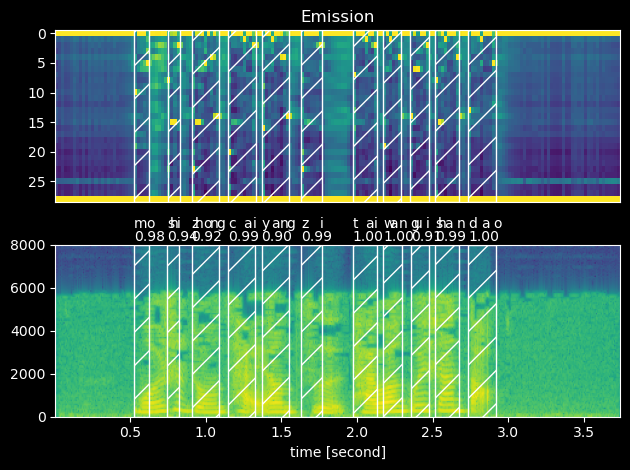

In [22]:
plot_alignments(waveform16k, token_spans, emission, transcript)
print("Raw Transcript: ", raw_text)
print("Normalized Transcript: ", transcript)
IPython.display.Audio(waveform16k, rate=16000)


In [23]:
preview_word(waveform16k, token_spans[0], num_frames, transcript[0])

mo (0.98): 0.523 - 0.624 sec


In [24]:
preview_word(waveform16k, token_spans[1], num_frames, transcript[1])

shi (0.94): 0.745 - 0.825 sec


In [24]:
def get_words(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
  words = []

  for span, word in zip(spans, transcript):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * span[0].start)
    x1 = int(ratio * span[-1].end)
    # print(f"{word} ({_score(span):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]

    words.append(segment.numpy())
  
  return words


In [25]:
get_words(waveform16k, token_spans, num_frames, transcript)

[array([[ 0.0008602 ,  0.00152547,  0.00146088, ..., -0.12834494,
         -0.17637731, -0.21712922]], dtype=float32),
 array([[0.05190656, 0.0598904 , 0.07408149, ..., 0.03356873, 0.03668607,
         0.04070076]], dtype=float32),
 array([[0.0181216 , 0.01834476, 0.01048384, ..., 0.02646755, 0.03330116,
         0.04097961]], dtype=float32),
 array([[-0.00456466, -0.00209737, -0.00218755, ...,  0.05800441,
          0.05843846,  0.05498751]], dtype=float32),
 array([[-0.01578683, -0.00539359,  0.00030392, ..., -0.03163794,
         -0.04327597, -0.05283451]], dtype=float32),
 array([[ 0.00092188,  0.00112764,  0.00146424, ...,  0.02488283,
          0.00154205, -0.03782079]], dtype=float32),
 array([[-0.00292676, -0.00162197, -0.00289358, ..., -0.17404167,
         -0.16074258, -0.14482822]], dtype=float32),
 array([[-0.06909257, -0.08633623, -0.09417263, ..., -0.0747348 ,
         -0.0637566 , -0.05508458]], dtype=float32),
 array([[-0.02763853, -0.02779888, -0.02619934, ..., -0.0338

In [28]:
def get_words(waveform, spans, num_frames) -> List[np.ndarray]:
  words = []

  for span in spans:
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * span[0].start)
    x1 = int(ratio * span[-1].end)
    segment = waveform[:, x0:x1]

    words.append(segment)
  
  return words

In [29]:
def driver(path, sentence):
  raw_text = re.sub(r'[^\w]', '', sentence)
  transcript = lazy_pinyin(raw_text)

  waveform48k, sample_rate = torchaudio.load(LARGE_MP3_DIR / path)

  resampler = T.Resample(orig_freq=48000, new_freq=16000)
  waveform16k = resampler(waveform48k[0:1])

  emission, token_spans = compute_alignments(waveform16k, transcript)
  num_frames = emission.size(1)

  words = get_words(waveform16k, token_spans, num_frames)

  return words
 

In [35]:
df.shape

(600247, 13)

In [36]:
samll = df[:100]

In [37]:
samll['segmented_audio'] = samll.progress_apply(lambda row: driver(row['path'], row['sentence']), axis=1)

Processing data: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s]
/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_26215/807193021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samll['segmented_audio'] = samll.progress_apply(lambda row: driver(row['path'], row['sentence']), axis=1)


In [39]:
from utils.data_processing import breakdown_pinyin

In [40]:
samll['pinyin_breakdown'] = samll['sentence'].progress_apply(breakdown_pinyin)

Processing data: 100%|██████████| 100/100 [00:00<00:00, 1942.20it/s]
/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_26215/844437691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samll['pinyin_breakdown'] = samll['sentence'].progress_apply(breakdown_pinyin)


In [42]:
samll['character'] = samll['sentence'].apply(lambda row: [char for char in re.sub(r'[^\w]', '', row)])

/var/folders/mz/73jxv48x3tb6l6wc7_wvd7t00000gn/T/ipykernel_26215/3264336854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samll['character'] = samll['sentence'].apply(lambda row: [char for char in re.sub(r'[^\w]', '', row)])


In [46]:
len(samll['segmented_audio'][0]) == len(samll['pinyin_breakdown'][0])

True

In [47]:
mask = samll.apply(lambda row: len(row['character']) == len(row['pinyin_breakdown']), axis=1)

In [50]:
samll.explode(['segmented_audio', 'character', 'pinyin_breakdown'], ignore_index=True)

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,segmented_audio,pinyin_breakdown,character
0,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(0.0009), tensor(0.0015), tensor(0.001...","(m, o, 2)",模
1,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(0.0519), tensor(0.0599), tensor(0.074...","(sh, i, 4)",式
2,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(0.0181), tensor(0.0183), tensor(0.010...","(zh, ong, 3)",种
3,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(-0.0046), tensor(-0.0021), tensor(-0....","(c, ai, 3)",采
4,25bc975d06200b7b1c9135db090561cb0d9b28d172e51c...,common_voice_zh-CN_19703883.mp3,33bf426e7162122b062710c1aee44949efea3fef159bbb...,模式种采样自台湾龟山岛。,NaN,1,0,thirties,female_feminine,出生地：31 上海市,NaN,zh-CN,NaN,"[[tensor(-0.0158), tensor(-0.0054), tensor(0.0...","(EMPTY, iang, 4)",样
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(-0.0174), tensor(-0.0240), tensor(-0....","(EMPTY, uei, 3)",委
1627,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(-0.0063), tensor(-0.0415), tensor(-0....","(EMPTY, van, 2)",员
1628,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(0.0217), tensor(0.0189), tensor(0.014...","(h, uei, 4)",会
1629,56d138a29f7850e806c48289e68a284506907d6d3ff2d7...,common_voice_zh-CN_22050256.mp3,60d9a59e86d5fec6814ab4eba0f29734973ed4980cd838...,会面导致穆夫提被巴基斯坦一个宗教委员会停职。,NaN,0,0,thirties,male_masculine,出生地：22 吉林省,NaN,zh-CN,NaN,"[[tensor(0.0009), tensor(-0.0043), tensor(-0.0...","(t, ing, 2)",停


In [54]:
samll[['path', 'sentence']].to_records(index=False).tolist()

[('common_voice_zh-CN_19703883.mp3', '模式种采样自台湾龟山岛。'),
 ('common_voice_zh-CN_19706151.mp3', '后者娶天之瓮主神。'),
 ('common_voice_zh-CN_19961025.mp3', '贝尔卢。'),
 ('common_voice_zh-CN_20051292.mp3', '日本与东帝汶的关系可追溯至第二次世界大战期间。'),
 ('common_voice_zh-CN_20051309.mp3', '单县各乡镇设有卫生院或医院。'),
 ('common_voice_zh-CN_20070076.mp3', '尤里二世当下便决定要在该地点建造大基捷日城。'),
 ('common_voice_zh-CN_20070223.mp3', '毛山鼠李为鼠李科鼠李属下的一个变种。'),
 ('common_voice_zh-CN_20070263.mp3', '遂吸收众多渴望消灾除难的人入道。'),
 ('common_voice_zh-CN_20070488.mp3', '毛山鼠李为鼠李科鼠李属下的一个变种。'),
 ('common_voice_zh-CN_20163037.mp3', '这项研究旨在了解一个地区的空间结构和性质。'),
 ('common_voice_zh-CN_20163057.mp3', '驯养的沙特瞪羚的基因分析显示它们有可能是不同的物种或混种。'),
 ('common_voice_zh-CN_20220279.mp3', '后其家移居台湾台北市。'),
 ('common_voice_zh-CN_20359866.mp3', '本条目记载了有关日本的妖怪。'),
 ('common_voice_zh-CN_20359996.mp3', '阿丽安萝德中扮演了其最重要的角色。'),
 ('common_voice_zh-CN_20391561.mp3', '格里梅尔斯豪森是德国图林根州的一个市镇。'),
 ('common_voice_zh-CN_20391684.mp3', '厌食症确诊的必要条件为明显过低的体重。'),
 ('common_voice_zh-CN_20409535.mp3', '请勿摄影、饮食、吸烟'),
 ('common